In [293]:
import numpy as np
from math import sqrt,cos,sin
from constants import SIMULATION_MAGNETON,SIMULATION_MASS,DEFAULT_ATOM_SPEED
import matplotlib.pyplot as plt
from latticeElements.elements import HalbachLensSim
from latticeElements.elements import  Drift as Drift_Sim
ROUNDING_ERROR=1e-14
def lens_transfer_matrix(K,L):
    phi=sqrt(K)*L
    A=cos(phi)
    B=sin(phi)/sqrt(K)
    C=-sqrt(K)*sin(phi)
    D=cos(phi)
    return np.array([[A,B],[C,D]])
def drift_transfer_matrix(L):
    return np.array([[1,L],[0,1]])
def full_transfer_matrix(elements):
    M=np.eye(2)
    for el in elements:
        M=el.M@M
    return M
def is_stable_lattice(elements):
    M_total=full_transfer_matrix(elements)
    eigenvalues_norm=np.abs(np.linalg.eig(M_total)[0])
    return np.all(eigenvalues_norm<=1.0+ROUNDING_ERROR)

def best_fit_magnetic_field(el):
    magnets=el.magnet.make_magpylib_magnets(False,False)
    x_vals=np.linspace(0.0,el.L,1000)
    y=rp*.333
    coords=arr_product(x_vals,[y],[0])
    F_y=SIMULATION_MAGNETON*magnets.B_norm_grad(coords)[:,1]
    Kappa=abs(np.trapz(F_y,x=x_vals))
    gamma=el.Lm*SIMULATION_MAGNETON*2*y/rp**2
    return Kappa/gamma

class Lens:
    def __init__(self,L,Bp,rp):
        assert L>0.0 and Bp>=0.0 and rp>0.0
        self.L=L
        self.Bp=Bp
        self.K=2*SIMULATION_MAGNETON*Bp/(SIMULATION_MASS*DEFAULT_ATOM_SPEED**2*rp**2)
        self.M=lens_transfer_matrix(self.K,L)
    def M_func(self,x):
        assert 0.0<=x<=self.L
        return lens_transfer_matrix(self.K,x)

class Drift:
    def __init__(self,L):
        assert L>0.0
        self.L=L
        self.M=drift_transfer_matrix(L)
    def M_func(self,x):
        assert 0.0<=x<=self.L
        return drift_transfer_matrix(x)

class Lattice:
    def __init__(self):
        self.elements=[]
    def add_drift(self,L):
        self.elements.append(Drift(L))
    def add_lens(self,L,Bp,rp):
        self.elements.append(Lens(L,Bp,rp))
    def is_stable(self):
        return is_stable_lattice(self.elements)
    def M_total(self):
        return full_transfer_matrix(self.elements)
    def trace(self,Xi):
        return self.M_total()@Xi
    def add_elements_from_sim_lens(self,el_lens):
        Bp=best_fit_magnetic_field(el_lens)
        L_lens,rp=el_lens.Lm,el_lens.rp
        L_drift=HalbachLensSim.fringe_frac_outer*rp
        self.add_drift(L_drift)
        self.add_lens(L_lens,Bp,rp)
        self.add_drift(L_drift)
    def build_matrix_lattice_from_sim_lattice(self,simulated_lattice):
        for el in simulated_lattice:
            if type(el) is Drift_Sim:
                self.add_drift(el.L)
            elif type(el) is HalbachLensSim:
                self.add_elements_from_sim_lens(el)
            else:
                raise NotImplementedError

In [366]:
from ParticleClass import Particle,Swarm
from ParticleTracerClass import ParticleTracer
from ParticleTracerLatticeClass import ParticleTracerLattice
from SwarmTracerClass import SwarmTracer

from helperTools import *
rp=.05
L=1.0
L_drift=.1
PTL=ParticleTracerLattice(lattice_type='injector')
for _ in range(6):
    PTL.add_halbach_lens_sim(rp,L)
    PTL.add_drift(L_drift)
PTL.end_lattice()
lattice=Lattice()
lattice.build_matrix_lattice_from_sim_lattice(PTL)
st=SwarmTracer(PTL)

In [367]:
lattice.is_stable()

False

In [368]:
yi_vals=2*(np.random.random(1000)-.5)*rp*.3
pyi_vals=2*(np.random.random(1000)-.5)*5.0
swarm_initial=Swarm()
for yi,pyi in zip(yi_vals,pyi_vals):
    swarm_initial.add_new_particle(qi=np.array([-1e-10,yi,0.0]),pi=np.array([-DEFAULT_ATOM_SPEED,pyi,0.0]) )
swarm=st.trace_swarm_through_lattice(swarm_initial,1e-5,1.0,copy_swarm=True)

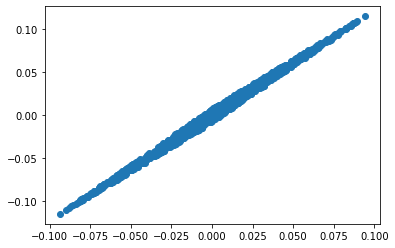

In [369]:
yf_vals=[]
yf_ang_vals=[]
for particle in swarm_initial:
    Xi=[particle.qi[1],particle.pi[1]/DEFAULT_ATOM_SPEED]
    yf,yf_ang=lattice.trace(Xi)
    yf_vals.append(yf)
    yf_ang_vals.append(yf_ang)
    plt.scatter(yf,yf_ang,c='C0')
plt.show()
yf_std_matrix,yf_ang_std_matrix=np.std(yf_vals),np.std(yf_ang_vals)

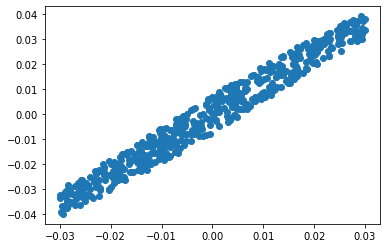

In [370]:
yf_vals=[]
yf_ang_vals=[]
for particle in swarm:
    if not particle.clipped:
        yf,yf_ang=particle.qf[1],particle.pf[1]/DEFAULT_ATOM_SPEED
        yf_vals.append(yf)
        yf_ang_vals.append(yf_ang)
        plt.scatter(yf,yf_ang,c='C0')
plt.show()
np.std(yf_vals),np.std(yf_ang_vals)
yf_std_sim,yf_ang_std_sim=np.std(yf_vals),np.std(yf_ang_vals)

In [337]:
matrix_lattice=Lattice()
rp=.03
L_drift=.05
matrix_lattice.add_drift(L_drift)
matrix_lattice.add_lens(.2,.5,rp)
matrix_lattice.add_drift(L_drift)
matrix_lattice.add_lens(.2,.5,rp)
matrix_lattice.add_drift(L_drift)

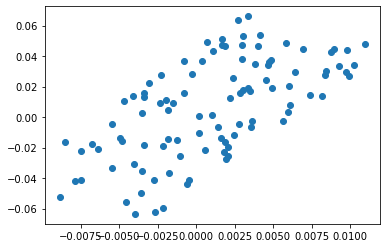

In [183]:
from ParticleClass import Particle,Swarm
from ParticleTracerClass import ParticleTracer
from ParticleTracerLatticeClass import ParticleTracerLattice
from SwarmTracerClass import SwarmTracer
PTL=ParticleTracerLattice(lattice_type='injector')
PTL.add_drift(L_drift-1.5*rp)
PTL.add_halbach_lens_sim(rp,.2)
PTL.add_drift(L_drift-1.5*rp)
PTL.add_halbach_lens_sim(rp,.2)
PTL.add_drift(L_drift-1.5*rp)
PTL.end_lattice()

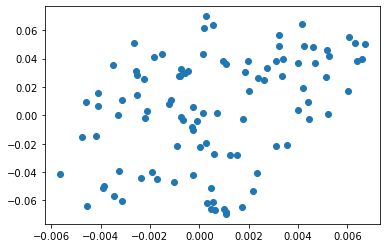

In [180]:
yf_vals=[]
yf_ang_vals=[]
for particle in swarm:
    yf,yf_ang=particle.qf[1],particle.pf[1]/DEFAULT_ATOM_SPEED
    yf_vals.append(yf)
    yf_ang_vals.append(yf_ang)
plt.scatter(yf_vals,yf_ang_vals)
plt.show()

In [143]:
def trace_to_s(s,X):
    assert 0.0<=s<=sum(lengths)
    el_index=np.argmax(s<length_cumulative)
    el=elements[el_index]
    delta_s=s-(length_cumulative[el_index]-lengths[el_index])
    if el_index==0:
        M=np.eye(2)
    else:
        M=full_transfer_matrix(elements[:el_index])
    M=el.M_func(delta_s)@M
    return M@X
s_vals=np.linspace(0.0,sum(lengths)-1e-3,1000)
X=np.array([.01,0.0])
Xf=np.array([trace_to_s(s,X) for s in s_vals])

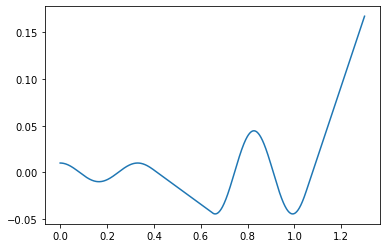

In [144]:

plt.plot(s_vals,Xf[:,0])
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from helperTools import *
from KevinBumperClass import swarmShift_x
from storageRingModeler import StorageRingModel,make_optimal_solution_model
from ParticleClass import Swarm
model=make_optimal_solution_model('2',use_bumper=False)


In [14]:
from ParticleClass import Particle
from ParticleTracerClass import ParticleTracer
pt=ParticleTracer(model.lattice_ring)
particle=Particle()
particle=pt.trace(particle,5e-6,3.0,fast_mode=False,use_energy_correction=True)

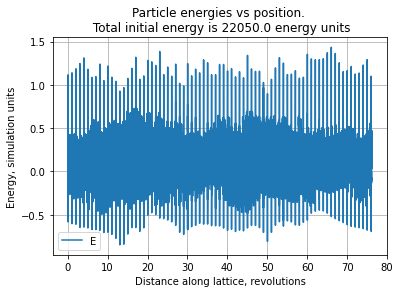

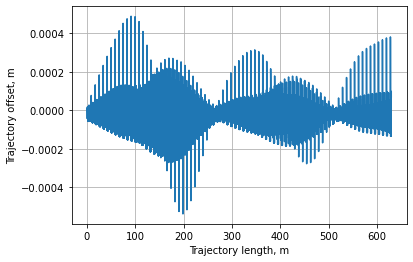

In [15]:
particle.plot_energies(show_only_total_energy=True)
particle.plot_orbit_reference_frame_position()

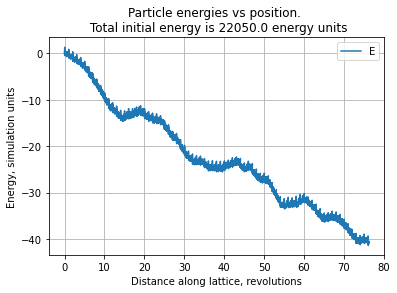

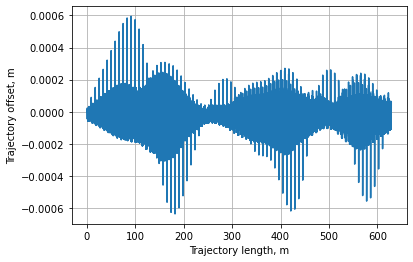

In [13]:
particle.plot_energies(show_only_total_energy=True)
particle.plot_orbit_reference_frame_position()

In [12]:
from scipy.signal import savgol_filter
speed=np.linalg.norm(particle.p_vals,axis=1)
print(np.nanmax(speed))
# plt.plot(speed)
speed=np.linalg.norm(particle.po_vals,axis=1)
print(np.nanmax(speed))
# plt.plot(speed)
# plt.show()

210.000005098867
210.000005098867


In [65]:
from math import ceil
from helperTools import is_close_all
def combiner_x_interp_vals(x1: float,x2: float,x3: float,x4: float,delta_nominal: float)-> np.ndarray:
    """Make x values (through axis) of interpolation grid for combiner"""
    assert x1<x2<x3<x4 and 0<delta_nominal<x3-x2
    intervals_b=round((x3-x2)/delta_nominal)
    steps_b=intervals_b+1
    vals_b=np.linspace(x2,x3,steps_b) #todo: rename x_vals_a, etc
    delta_b=vals_b[1]-vals_b[0]
    vals_c=np.arange(x3,x4,delta_b)+delta_b
    vals_a=np.flip(np.arange(x2,x1,-delta_b))-delta_b
    vals=np.concatenate((vals_a,vals_b,vals_c))
    deltas=np.gradient(vals)
    is_close_all(deltas,delta_b,1e-12)
    assert vals[0]<x1 and vals[-1]>x4
    return vals


array([0.007408, 0.017696, 0.027984, 0.038272, 0.04856 , 0.058848,
       0.069136, 0.079424, 0.089712, 0.1     , 0.110288, 0.120576,
       0.130864, 0.141152, 0.15144 , 0.161728, 0.172016, 0.182304,
       0.192592, 0.20288 , 0.213168, 0.223456, 0.233744, 0.244032,
       0.25432 , 0.264608, 0.274896, 0.285184, 0.295472, 0.30576 ,
       0.316048, 0.326336, 0.336624, 0.346912, 0.3572  , 0.367488,
       0.377776, 0.388064, 0.398352, 0.40864 , 0.418928, 0.429216,
       0.439504])

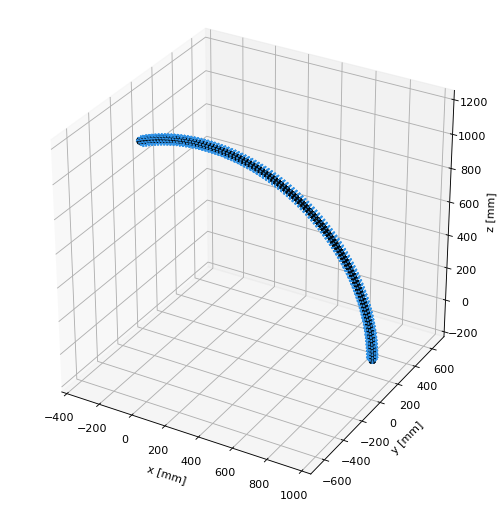

In [13]:
from HalbachLensClass import SegmentedBenderHalbach
import numpy as np
num_mags=100
bender=SegmentedBenderHalbach(.01,1.0,.01,.0254/2,"N52",num_mags,(True,True),use_pos_mag_angs_only=True)
bender.show()

In [9]:
import numpy as np

from ParticleClass import Particle
from ParticleTracerClass import ParticleTracer
from ParticleTracerLatticeClass import ParticleTracerLattice
from SwarmTracerClass import SwarmTracer
import matplotlib.pyplot as plt
%matplotlib inline


PTL = ParticleTracerLattice(use_mag_errors=False,field_dens_mult=1,include_mag_cross_talk=True,include_misalignments=True)
PTL.add_drift(.25)
PTL.add_combiner_sim_lens(.2,.05)
PTL.add_drift(.25)
PTL.end_lattice()

st = SwarmTracer(PTL)
pt = ParticleTracer(PTL)
#0.8610285714285715


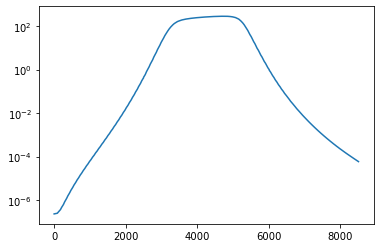

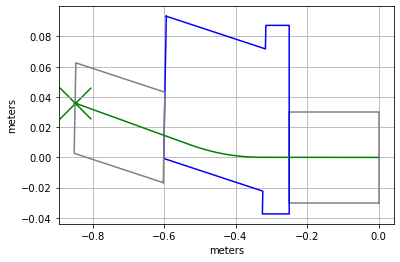

array([-8.48980572e-01,  3.59377276e-02, -1.25150307e-04])

In [10]:
particle = Particle(qi=np.array([-1e-10, 0e-3, 0.0]),pi=np.array([-200.0,0.0,0.]))
particle = pt.trace(particle, 5e-7, 1.0, fast_mode=False)
plt.semilogy(particle.V_vals)
plt.show()
PTL.show_lattice(particle=particle,true_aspect_ratio=False)
particle.qf

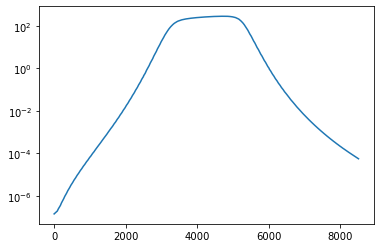

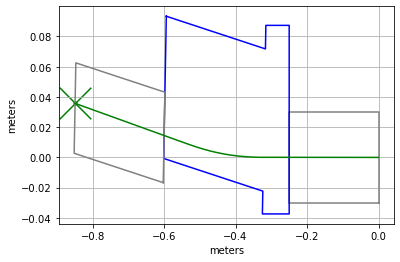

array([-8.49011725e-01,  3.57414938e-02, -5.97587160e-05])

In [6]:
particle = Particle(qi=np.array([-1e-10, 0e-3, 0.0]),pi=np.array([-200.0,0.0,0.]))
particle = pt.trace(particle, 5e-7, 1.0, fast_mode=False)
plt.semilogy(particle.V_vals)
plt.show()
PTL.show_lattice(particle=particle,true_aspect_ratio=False)
particle.qf

In [ ]:
from helperTools import arr_product
magnet=PTL[1].magnet
x_vals=[PTL[1].L/2]
y_vals=np.linspace(-.05,.05)
coords=arr_product(x_vals,y_vals,y_vals)
valid_indices=magnet.get_valid_coord_indices(coords,1e-6,True)
for coord,is_valid in zip(coords,valid_indices):
    c='g' if is_valid else 'r'
    plt.scatter(coord[1],coord[2],c=c)
plt.show()

In [ ]:
particle = Particle(qi=np.array([-1e-10, 10e-3, 0.0]),pi=np.array([-10.0,0.0,0.]))
particle = pt.trace(particle, 5e-7, 1.0, fast_mode=False)
particle.plot_orbit_reference_frame_position()
PTL.show_lattice(particle=particle,true_aspect_ratio=False)

In [57]:
from latticeElements.Magnets import misalignment_transform_parameters
magnet.alignment_shifts=(0,0.0,0,.0,0.02)


def transform_coords_to_misaligned(coords,magnet):
    """Transform coords into the misalignment frame to ease analysis of wether they are valid.
    Go in reverse order of the misalignment procedure"""
    rotation_origin, R1, R2, r_shift=misalignment_transform_parameters(magnet)
    R1, R2=R1.as_matrix(), R2.as_matrix()
    coords-=r_shift
    coords=(coords-rotation_origin).T
    coords=np.linalg.inv(R2)@coords
    coords=np.linalg.inv(R1)@coords
    coords=coords.T+rotation_origin
    return coords


In [58]:
from helperTools import arr_product
x_vals=np.linspace(0,PTL[1].L)
y_vals=np.linspace(0,PTL[1].rp*1.5)
coords=arr_product(x_vals,y_vals,y_vals)
indices=magnet.get_valid_coord_indices(coords,1e-6)

sum(indices)/len(indices)

0.76496

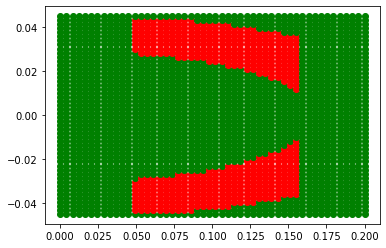

In [59]:

x_vals=np.linspace(0,PTL[1].L)
y_vals=np.linspace(-PTL[1].rp*1.5,PTL[1].rp*1.5)
z_vals=[0]
coords0=arr_product(x_vals,y_vals,z_vals)
coords=coords0
coords-=r_shift
coords=(coords-r_shift).T
coords=R2@coords
coords=R1@coords
coords=coords.T+r_shift
are_valid=magnet.get_valid_coord_indices(coords,1e-6)
for coord,is_valid in zip(coords0,are_valid):
    c='g' if is_valid else 'r'
    plt.scatter(coord[0],coord[1],c=c)
plt.show()

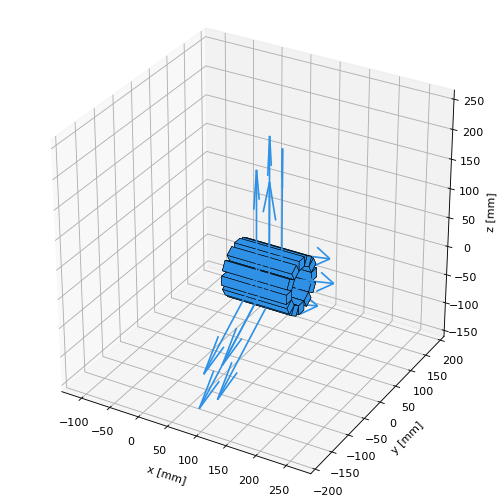

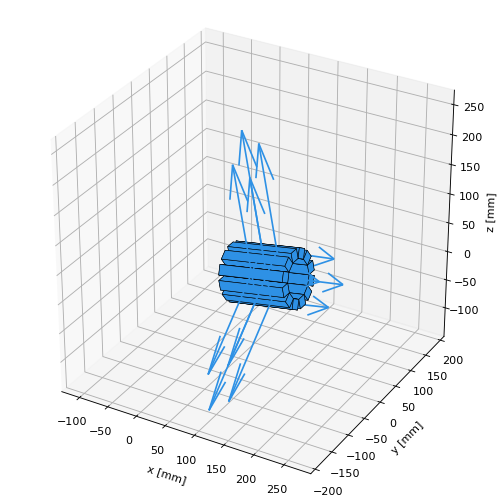

In [60]:
from shapely.geometry import box
from shapely.affinity import translate,rotate
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
import copy

magnet.make_magpylib_magnets(False,include_misalignments=False).show()
magnet.make_magpylib_magnets(False,include_misalignments=True).show()

In [23]:
numbers=[1,2,2,3,3,4,4,4,5]
numbers_unique=[]
for number in numbers:
    if number not in numbers_unique:
        numbers_unique.append(number)
numbers_unique

[1, 2, 3, 4, 5]

In [96]:
from constants import BOLTZMANN_CONSTANT, MASS_LITHIUM_7,BHOR_MAGNETON

V=600e-3*BOLTZMANN_CONSTANT

from math import asin,sin
asin(37.7/210)
rp=.05
delta=V/rp**2
theta=.18/1.44
s=210.0
L=((V-.5*MASS_LITHIUM_7*(theta*s)**2)/(delta*theta**2))**.5
L

0.2871810983873865

In [97]:
import sympy as sym
phi=sym.symbols('phi', real=True)
alpha, r, theta, theta_0,F0,D,L=sym.symbols('alpha r theta theta_0 F0 D L', real=True,positive=True)
# alpha=1
f=sym.cos(theta*alpha)**2 / r**2
da=r**2*sym.sin(theta)
integrand=f*da
theta_max=(sym.pi/2)/alpha
integral=sym.integrate(integrand,(theta,0,theta_max),(phi,0,2*sym.pi)  ).args[1][0]
# Flux
sigma=1/integral.simplify()
Flux_theta=sym.integrate(F0*sigma*integrand,(theta,0,theta_0),(phi,0,2*sym.pi)  ).args[1][0]

In [177]:
import numpy as np
import matplotlib.pyplot as plt
f=sym.cos(theta*alpha)**2 / r**2
da=r**2*sym.sin(theta)
integrand=f*da
theta_max=(sym.pi/2)/alpha
def integrate(limit):
    return 1/(sym.integrate(integrand,(theta,0,theta_max)).args[0][0].subs(alpha,limit))
limits=np.linspace(1,1.2,30)
# vals=[integrate(limit) for limit in limits]
float(integrate(1.2))

4.19530687022535

In [194]:
L=16
D=2.54
gamma=3.57
frac=1e2*(gamma/2)*((D/2)/L)**2
frac

1.1246197265625

In [188]:
1.94*.01**2

0.000194

In [171]:
thing=sym.integrate(integrand,(theta,0,theta_max)).args[0][0]
sym.simplify(sym.series(thing,alpha,1,2).removeO())

(4 - 3*pi)*(alpha - 1)/9 + 1/3

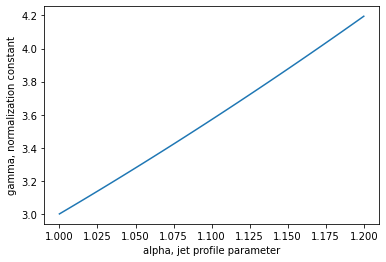

In [163]:
plt.plot(limits,vals)
plt.ylabel('gamma, normalization constant')
plt.xlabel('alpha, jet profile parameter')
plt.show()

In [123]:
Flux=sym.series(Flux_theta,theta_0,0,3).removeO()#.subs(theta_0,(D/2)/L)
# sym.N(Flux.subs(L,2.0).subs(alpha,1.15).subs(D,1e-3).subs(F0,.0125*60))
# Flux.subs(alpha,1.0)
display(Flux.subs(alpha,1))
# Flux=sym.series(Flux_theta,theta_0,0,3).removeO().subs(theta_0,(D/2)/L).subs(alpha,1)
Flux.subs(alpha,1)#.subs(theta_0,(D/2)/L)

2*F0*theta_0**2/3

2*F0*theta_0**2/3

In [28]:
from HalbachLensClass import HalbachLens
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
L0=6*.0254
mag_widths=(.0254,1.5*.0254)
radii=(.05,.05+mag_widths[0])
lens=HalbachLens(radii, mag_widths,L0,'N52')
# lens.show()
dx=1e-6
q0=np.array([0.0,0,0])
lens.B_norm_grad(q0,diff_method='central',dx=dx)
# q1=np.array([0.0,dx,0.0])
# q2=np.array([0.0,-dx,0.0])
# lens.B_norm(q1)-lens.B_norm(q2)

0
[[1.e-06 0.e+00 0.e+00]]
[4.86057422e-10]
[[-1.e-06  0.e+00  0.e+00]]
[4.86058328e-10]
[-9.05942146e-16] 2e-06
1
[[0.e+00 1.e-06 0.e+00]]
[4.86058052e-10]
[[ 0.e+00 -1.e-06  0.e+00]]
[4.86058624e-10]
[-5.71986478e-16] 2e-06
2
[[0.e+00 0.e+00 1.e-06]]
[5.03475788e-16]
[[ 0.e+00  0.e+00 -1.e-06]]
[5.03475788e-16]
[0.] 2e-06


array([-4.52971073e-10, -2.85993239e-10,  0.00000000e+00])

In [41]:
q0=np.array([0.0,0,0])
lens.B_norm(q0)

2.7173034561617646e-16

1e-20

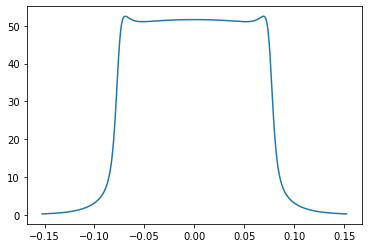

7.782067296936666

In [3]:
num_points=1000
x0=.045/1.41
y0=0.045/1.41
z_vals=np.linspace(-L0,L0,num_points)
coords=np.column_stack((np.ones(num_points)*x0,np.ones(num_points)*y0,z_vals))
F_trans=np.linalg.norm(lens.B_norm_grad(coords)[:,:2],axis=1)
plt.plot(z_vals,F_trans)
plt.show()
F0=F_trans[round(len(z_vals)/2)]
L=np.trapz(F_trans,x=z_vals)/F0
1e2*(L-L0)/L0

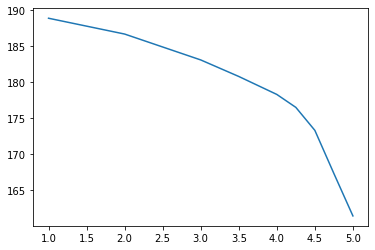

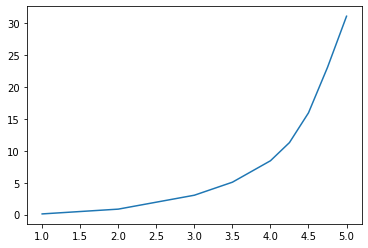

In [5]:
from helperTools import make_dense_curve_1D_RBF
ap=np.array([5.0,4.75,4.5,4.25,4,3.5,3,2,1])
loc=np.array([161.4,167.3,173.3,176.5,178.3,180.8,183.1,186.7,188.9])
size=np.array([31.09,23.08,15.95,11.29,8.44,5.08,3.04,.86,.11])
plt.plot(ap,loc)
plt.show()
plt.plot(ap,size)
plt.show()
np.savetxt("apdata2",np.column_stack((ap,loc,size)))

In [39]:
def convert_file_to_lower_case_words(file_name):
    file=open(file_name)
    #do the splitting and lowercasing here
    pass
def make_script_list(file_name):
    words=convert_file_to_lower_case_words(file_name)
    script_list=[]
    for word in words:
        if word not in script_list:
            script_list.append(word)
    return script_list
def num_occurences_in_word(word, sub_string):
    # count the occurences of the sub_string in word
    pass
def num_occurences_in_words(words,sub_string):
    # count the occurences of the sub_string in words
    counts=0
    for word in words:
        counts+= num_occurences_in_word(word, sub_string)


b b
r r
a a
v v
o o
a a
l l
p p
h h
a a
z z
u u
l l
u u
c c
h h
a a
r r
l l
i i
e e


In [35]:
fruits=['apple','orange']
veggies=['carrot','spinach']
for thing in fruits:
    for thing in veggies:
        print(thing)

carrot
spinach
carrot
spinach


In [64]:
letter_to_count='a'
word='fataass'
index=0
counts=0
while index!=-1:
    index=word.find(letter_to_count,index+1)
    counts+=1
counts

4

In [65]:
letter_to_count='a'
word='fataass'
from_index=0
letter_index=None
counts=0
while letter_index!=-1:
    letter_index=word.find(letter_to_count,from_index)
    from_index=letter_index+1
    counts+=1
counts

4

In [74]:
word='fataass'
letter='a'
letter_index=word.find('a')
print(letter_index)
letter_index=word.find('a',letter_index+1)
print(letter_index)
letter_index=word.find('a',letter_index+1)
print(letter_index)

letter_index=word.find('a',letter_index+1)
print(letter_index) #OH! it's -1, that means it's done! no more letters. We counted 3

1
3
4
-1


In [76]:
letters=['a','b','c','d','e','f']
stop_letter='d'
index=0
while stop_letter!=letters[index]:
    print(letters[index])
    index+=1

a
b
c


In [58]:
from constants import BOLTZMANN_CONSTANT,MASS_LITHIUM_7
sigma=5e-13 #cm^2
T=.01
flux_mult=1
F=5e16
forward_speed=210.0 * 1e2 #cm/ s
bore_radius=.7
area=np.pi*bore_radius**2
density=flux_mult*F/(forward_speed*area)
speed=np.sqrt(8*BOLTZMANN_CONSTANT*T/MASS_LITHIUM_7)
tau=1/(np.sqrt(2)*speed*density*sigma)
100/tau

1064.895256136423

In [4]:
import numpy
from PIL import Image, ImageDraw

# polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
width = 100
height = 100


# ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)

[10000,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


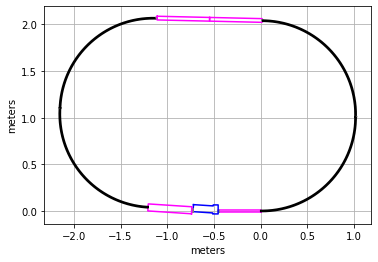

In [48]:
lattice_ring=model.lattice_ring
lattice_ring.show_lattice()

In [51]:
for el in lattice_ring:
    print(type(el).__name__,round(100*el.L),round(100*el.ap,1))

HalbachLensSim 44 0.9
Drift 1 1.0
CombinerHalbachLensSim 27 3.8
Drift 2 1.8
HalbachLensSim 47 3.8
HalbachBenderSimSegmented 155 0.7
Drift 0 0.8
HalbachBenderSimSegmented 154 0.7
Drift 1 0.8
HalbachLensSim 56 2.0
HalbachLensSim 56 2.0
Drift 1 0.8
HalbachBenderSimSegmented 157 0.7
Drift 0 0.8
HalbachBenderSimSegmented 157 0.7


In [97]:
from helperTools import *
from magpylib.magnet import Cuboid
from constants import MAGNETIC_PERMEABILITY
mTESLA_TO_TESLA = 1e-3
mm_to_meter=1e-3
magpyMagnetization_ToSI: float = 1 / (1e3 * MAGNETIC_PERMEABILITY)
SI_MagnetizationToMagpy: float = 1 / magpyMagnetization_ToSI

mag_dim_mm=(10,10,10)
M=1e6
magnetization=(M*SI_MagnetizationToMagpy,0,0)
magnet = Cuboid(magnetization=magnetization, dimension=mag_dim_mm,
             position=(0,0,0))
coil_diam_mm=12
N=100


def flux(delta_x):
    coil_y_coords=np.linspace(-coil_diam_mm/2,coil_diam_mm/2,100)
    coil_area_coords=arr_product([delta_x],coil_y_coords,coil_y_coords)
    coil_area_coords=coil_area_coords[np.linalg.norm(coil_area_coords[:,1:],axis=1)<coil_diam_mm/2]
    da=N*(mm_to_meter*(coil_y_coords[1]-coil_y_coords[0]))**2
    print(da*len(coil_area_coords))
    B_x=magnet.getB(coil_area_coords)[:,0]*mTESLA_TO_TESLA
    return np.sum(B_x*da)

emf_time_mv=1e3*(flux(0)-flux(50))
emf_time_mv

0.01126611570247932
0.01126611570247932


8.22918124841902

In [72]:
from ParticleTracerLatticeClass import ParticleTracerLattice
PTL=ParticleTracerLattice(lattice_type='injector')
r_inner=5.0
r_outer=r_inner
PTL.add_drift()

0.000176625

In [23]:
#todo: add pressure profile business
#todo: add aperture?
#todo: add constant pressure chamber?

2.482000201450435e-05

In [ ]:
from vacuumanalyzer.vacuumanalyzer import VacuumSystem,solve_vac_system
from math import sqrt
def conductance_aperture(D,m,T=293.0):
    return 2.9*sqrt(T/m)*D**2
P0=1e-6
Q=P0*conductance_aperture(1,4)
vac_sys=VacuumSystem()
vac_sys.add_chamber(Q=Q)
vac_sys.add_tube(32,2.2)
vac_sys.add_chamber(S=100)
vac_sys.add_tube(15,1.7)
vac_sys.add_chamber(S=100)
vac_sys.add_tube(20,2)
# vac_sys.add_chamber(S=100)
vac_sys.add_tube(40,2.5)
vac_sys.add_chamber(S=100)
# vac_sys.add_tube(25,1.3)
solve_vac_system(vac_sys)
print(vac_sys.chambers()[-1])

In [100]:
k=1.38e-23
P=1.3332e-7
n=P/(k*300)
(n*1e-6)/1e6

32.20289855072463

In [108]:
P=1.7e-10 * 133
n=P/(k*300)
(n*1e-6)*6e-9
(1e-6*P/(k*300))/1e6

5.461352657004831

In [125]:
(1.5e-15/(k*300/(80*133)))/1e9,(6e-15/(k*300/(80*133)))/1e10
(1/1.5e10)

6.666666666666667e-11

In [5]:
%matplotlib tk
model.show_floor_plan_with_trajectories(T_max=.01)

In [8]:
%matplotlib tk
from helperTools import plt
from ParticleTracerClass import ParticleTracer
from SwarmTracerClass import SwarmTracer
PTL=model.lattice_injector
x,y,_=PTL.combiner.r1
# st=SwarmTracer(PTL)
# swarm=st.initialize_simulated_collector_focus_swarm(100)
# swarm=st.trace_swarm_through_lattice(swarm,1e-5,1.,use_fast_mode=False)
pt=ParticleTracer(PTL)
particle=pt.trace(None,1e-5,.01)
PTL.show_lattice(particle=particle,plot_inner=True,plot_outer=True,show_immediately=False)
# plt.scatter(x,y,marker='o',s=100)
plt.show()

# PTL.show_lattice(particle=particle)



In [17]:
print(model.lattice_injector.combiner.input_offset,model.lattice_ring.combiner.input_offset)
print(model.lattice_injector.combiner.ang,model.lattice_ring.combiner.ang)
print(model.lattice_injector.combiner.Lm,model.lattice_ring.combiner.Lm)
print(model.lattice_injector.combiner.input_offset-model.lattice_ring.combiner.input_offset)
print(model.lattice_injector.combiner.rp,model.lattice_ring.combiner.rp)
print((model.lattice_injector.combiner.input_offset+model.lattice_ring.combiner.input_offset)/2)

-0.029964116352615842 -0.016662352428343963
-0.08491247104692867 0.07079696627006075
0.17047182734978528 0.17047182734978528
-0.013301763924271879
0.04 0.04
-0.0233132343904799


In [2]:
L1=model.lattice_ring.el_list[1].L
L1+=model.lattice_ring.el_list[0].fringe_frac_outer*model.lattice_ring.el_list[0].rp
L1+=model.lattice_ring.combiner.space
# L1
%matplotlib tk
model.show_floor_plan()
L1

0.08889999999999999

In [1]:
from ParticleTracerLatticeClass import ParticleTracerLattice
from helperTools import *
PTL=ParticleTracerLattice(lattice_type='injector')
PTL.add_drift(.1)
PTL.add_drift(.1,input_tilt_angle=.1,output_tilt_angle=-.2)
PTL.add_drift(.1,output_tilt_angle=.1)
PTL.add_combiner_sim_lens(.2,.02)
PTL.end_lattice()

# PTL.show_lattice()


In [4]:
from latticeElements.combiner_characterizer import  make_halbach_combiner_force_function,compute_particle_trajectory
from latticeElements.elements import Drift,HalbachLensSim,CombinerHalbachLensSim

def combiner_Halbach_xy(el):
    atom_state = 'HIGH_FIELD_SEEKER' if el.field_fact == -1 else 'LOW_FIELD_SEEKER'
    force_Func = make_halbach_combiner_force_function(el)
    q_arr, _ = compute_particle_trajectory(force_Func, el.PTL.speed_nominal, 0.0, 2 * el.space + el.Lm,
                                          particle_y_offset_start=el.output_offset, atom_state=atom_state)
    xy=q_arr[:,:2]
    for i,coord in enumerate(xy):
        xy[i]=el.R_Out@coord
    xy+=el.r2[:2]
    return xy

def straight_xy(el):
    xy=np.array([[0.0,0.0],[el.L,0.0]])
    for i,coord in enumerate(xy):
        xy[i]=el.R_Out@coord
    xy+=el.r1[:2]
    return xy

In [6]:
%matplotlib tk


el=PTL.el_list[0]
def make_Particle_Trajectory(el):
    if type(el) in (Drift,HalbachLensSim):
        xy=straight_xy(el)
    else:
        xy=combiner_Halbach_xy(el)

    xy_plot_format=list(xy.T)
    return xy_plot_format


PTL.show_lattice(show_immediately=False)
for el in PTL.el_list:
    plt.plot(*make_Particle_Trajectory(el))

In [10]:
from latticeElements.utilities import halbach_magnet_width
from helperTools import inch_to_meter
import numpy as np
halfAngle = 2 * np.pi / 24
magnet_width=inch_to_meter(3/16)
print(magnet_width)
magnetSeparation=inch_to_meter(.005)
# maxMagnetWidth = rp * np.tan(halfAngle) * 2
widthReductin = magnetSeparation / np.cos(halfAngle)
# magnet_width -= widthReductin

rp=inch_to_meter(5/8)/2.0
(halbach_magnet_width(rp)/.0254)/(1/16)

0.004762499999999999


2.516456305349009

In [48]:
from helperTools import *
from math import floor





16.000000000001


0.0254

In [ ]:
np.arange(1,16)


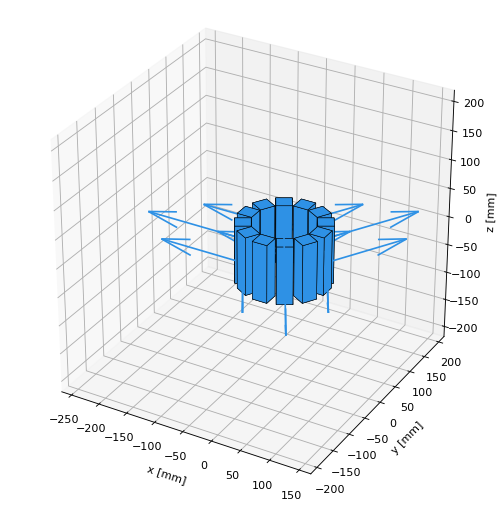

In [3]:
from HalbachLensClass import HalbachLens
lens=HalbachLens(.05,.025,.1,'N52')
lens.show()
lens.B_vec()

In [16]:
sources=lens2.sources_all
Collection([*lens1.copy().sources_all,*sources],override_parent=True)

Collection(id=6085426240)

In [42]:
class foo:
    def __init__(self):
        pass
    @staticmethod
    def a(b):
        return b+5.0
foo.a(1.0)

6.0

In [61]:
from constants import MAGNETIC_PERMEABILITY
lam=.0005/MAGNETIC_PERMEABILITY
r=500e-6
sigma=lam*2*r/(np.pi*(1e3*r)**2)
sigma

0.506605917935905

In [247]:
swarmSystemTraced=Swarm()
for particleInjector,particle_ring in zip(swarm_injector_traced.particles,swarmRingTraced.particles):
    assert particleInjector.traced is True
    particle=Particle(qi=particleInjector.qi,pi=particleInjector.pi)
    particle.traced=True
    didParticleInjectorClip=particleInjector.clipped or model.does_ring_clip_injector_particle(particleInjector)
    if didParticleInjectorClip:
        particle.clipped=didParticleInjectorClip
    else:
        particle.T=particleInjector.T+particle_ring.T
        particle.clipped=particle_ring.clipped
    swarmSystemTraced.add(particle)
len(swarmSystemTraced.particles)

4995

-0.002004008016032177 -0.002004008016032177


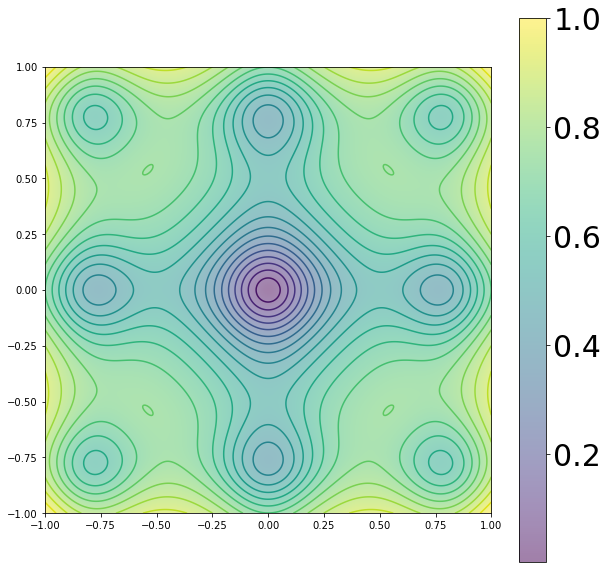

In [140]:
from helperTools import *
xEdge=np.linspace(-1,1,500)
yEdge=np.linspace(-1,1,500)
X,Y=np.meshgrid(xEdge,yEdge)
x_arr=np.ravel(X)
y_arr=np.ravel(Y)
np.random.seed(42)
def func(x,y):
    x=1.25*x
    y=1.25*y
    arg1 = -0.2 * np.sqrt(0.5 * (x ** 2 + y ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x) + np.cos(2. * np.pi * y))
    return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e+np.random.random_sample()*.0
v=np.array([func(x,y) for x,y in zip(x_arr,y_arr)])
v/=v.max()
print(x_arr[np.argmin(v)],y_arr[np.argmin(v)])
v=v.reshape((len(yEdge),len(xEdge)))
plt.figure(figsize=(10,10))
plt.imshow(v,alpha=0.5,extent=[xEdge.min(),xEdge.max(),yEdge.min(),yEdge.max()])
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=30)
plt.contour(X,Y,v,20)

plt.show()

In [178]:
import matplotlib
xEdge=np.linspace(0,1.5,200)
yEdge=np.linspace(0,1.5,200)
X,Y=np.meshgrid(xEdge,yEdge)
x_arr=np.ravel(X)
y_arr=np.ravel(Y)
np.random.seed(42)
a,b=1,100
def func(x,y):
    return ((a-x)**2+b*(y-x**2)**2)*(1+np.random.random_sample()*.5)
v=np.array([func(x,y) for x,y in zip(x_arr,y_arr)])
v[v<1e-6]=1e-6
# v=np.log10(v)
v=v.reshape((len(yEdge),len(xEdge)))
plt.figure(figsize=(10,10))
plt.imshow(v,alpha=0.5,extent=[xEdge.min(),xEdge.max(),yEdge.min(),yEdge.max()],norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar()
# cbar.ax.tick_params(labelsize=30)
# plt.contour(X,Y,v,20)

plt.show()
v.min()

0.0007680184177805239

In [175]:
from octopusOptimizer import octopus_Optimize
a,b=1,100
def func(args):
    x,y=args
    return (a-x)**2+b*(y-x**2)**2+np.random.random_sample()*.5
xi=[0,0]
bounds=[(-5,5),(-5,5)]
octopus_Optimize(func,bounds,xi,processes=1)

best of iter: 0 1.1494560206022082 array([0, 0])
didnt find food
best of iter: 1 1.1494560206022082 array([0, 0])


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


found food
best of iter: 2 0.9405631251866033 array([ 0.1       , -0.00869327])
found food
best of iter: 3 0.8455703375406206 array([ 0.10196765, -0.00842964])
didnt find food
best of iter: 4 0.8455703375406206 array([ 0.10196765, -0.00842964])
didnt find food
best of iter: 5 0.8455703375406206 array([ 0.10196765, -0.00842964])
found food
best of iter: 6 0.8389334718944604 array([0.10055483, 0.00042187])
didnt find food
best of iter: 7 0.8389334718944604 array([0.10055483, 0.00042187])
didnt find food
best of iter: 8 0.8389334718944604 array([0.10055483, 0.00042187])
didnt find food
best of iter: 9 0.8389334718944604 array([0.10055483, 0.00042187])
didnt find food
best of iter: 10 0.8389334718944604 array([0.10055483, 0.00042187])


KeyboardInterrupt: 

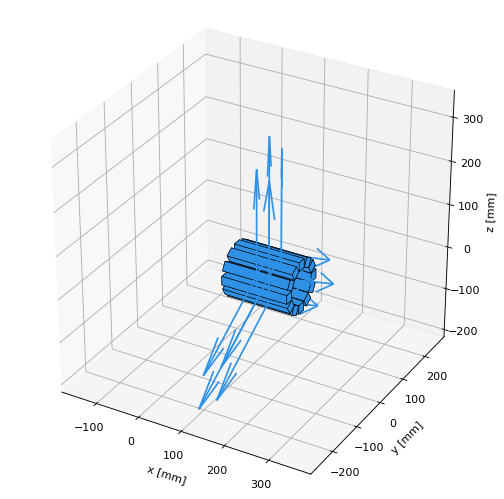

In [2]:
from latticeElements.combiner_characterizer import compute_particle_trajectory
from HalbachLensClass import HalbachLens
from helperTools import *
from scipy.spatial.transform import Rotation as Rot
%matplotlib inline
from constants import SIMULATION_MAGNETON
rp=.04
Lm=.15
space=1.5*rp
def make_Combiner_Force_And_Energy_Function():
    orientation=Rot.from_rotvec([0,np.pi/2,0.0])
    lens=HalbachLens(rp,rp/2.0,Lm)
    lens.rotate(orientation)
    lens.move((space+Lm/2,0,0))
    lens.show()
    def force(q):
        F=-SIMULATION_MAGNETON*lens.B_norm_grad(q)
        F[2]=0.0
        return F
    def energy(q):
        return lens.B_norm(q)*SIMULATION_MAGNETON
    return force, energy
force,energ=make_Combiner_Force_And_Energy_Function()

In [35]:
from HalbachLensClass import HalbachLens
from helperTools import inch_to_meter,arr_product,make_image_cartesian
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
r_inner=inch_to_meter(.952)
width_inner=inch_to_meter(.5)
width_outer=inch_to_meter(.75)
r_outer=inch_to_meter(1.463)
length=inch_to_meter(7.875)
lens=HalbachLens((r_inner,),(width_inner,),length,'N52')
R=Rot.from_rotvec([0,0,np.pi/6])
lens.rotate(R)
# lens.move((.05,0.08,0))


%matplotlib tk
# lens.show()

x_max=r_outer+width_outer*1.5
x_arr=np.linspace(-x_max,x_max,300)
z_list=[0]
coords=arr_product(x_arr,x_arr,z_list)
By=lens.B_vec(coords)[:,1]
image=By.reshape(len(x_arr),len(x_arr))
image=np.rot90(image)
plt.imshow(image)
plt.colorbar()
plt.show()

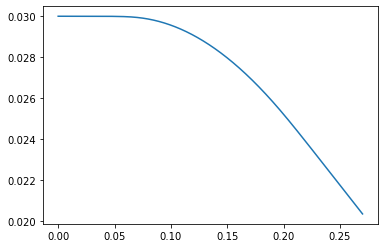

-0.07035747136998269

In [11]:
q_arr,p_arr=compute_particle_trajectory(force,210.0,0,Lm+2*space,particle_y_offset_start=-3e-2)
angle=np.tan(p_arr[-1][1]/p_arr[-1][0]) #-0.02339164110843338
plt.plot(q_arr[:,0],q_arr[:,1])
plt.show()
angle

In [13]:
wallThickness=1e-3
ap=.8*rp
lensCorner=np.array([space+Lm+wallThickness,-ap,0.0])
np.min(np.linalg.norm(q_arr-lensCorner,axis=1))

0.056338396476225405

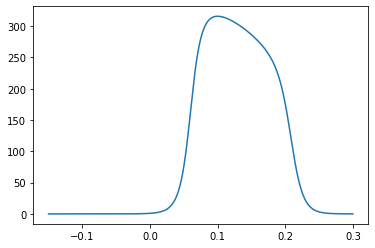

In [62]:
E=energy(q_arr)
plt.plot(q_arr[:,0],E)
plt.show()

In [63]:
EStart=E[np.argmax(q_arr[:,0]>0)]
xEndEqualEnergy=q_arr[:,0][np.argmax(q_arr[:,0]>L+2*space)]
# E[len(E)-np.argmax(np.flip(E)>EStart)]
xEndEqualEnergy,L+2*space

(0.2701963532644307, 0.27)

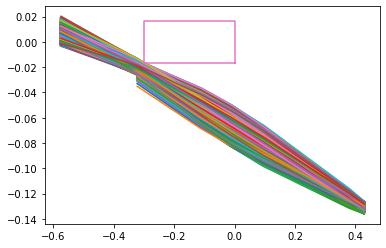

(108.3921891424954, 271.36403180203695)

In [4]:
%matplotlib inline
swarm=model.trace_through_injector_and_transform_to_ring(False)
swarm.num_particles(weighted=True),model.swarm_injector_initial.num_particles(weighted=True) #(116.35938725733523, 271.36403180203695)

In [3]:
swarm_injector_traced = model.swarm_tracer_injector.trace_swarm_through_lattice(
    model.swarm_injector_initial.quick_copy()
    , model.h, 1.0, parallel=False, copy_swarm=False,
    accelerated=False,log_el_phase_space_coords=True)

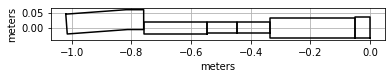

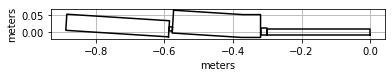

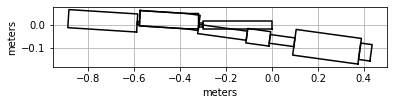

In [4]:
model.lattice_injector.show_lattice()
model.lattice_ring.show_lattice()
model.show_floor_plan()

In [23]:
from skopt import Optimizer
import numpy as np
from helperTools import low_discrepancy_sample
import time
def func(X):
    return np.exp(np.linalg.norm(X))+np.sin(3*X[0]+np.pi/.53243)+np.cos(X[1])-np.sin(2*X[2])
bounds=[(-1.0,1.0),(-1.,1.0),(-1.0,1.0)]
_initCoords=low_discrepancy_sample(bounds,1_000_000)
_vals=[func(coord) for coord in _initCoords]
x_min=_initCoords[np.argmin(_vals)]
valMin=np.min(_vals)
x_min,valMin

(array([-0.29231071,  0.01222432,  0.40662479]), 0.9716902150985816)

In [55]:

initCoords=low_discrepancy_sample(bounds,200)
vals=[func(coord) for coord in initCoords]
initCoords=[list(coord) for coord in initCoords]
t=time.time()
opt=Optimizer(bounds,base_estimator='GP',acq_func='EI')
for _ in range(1):
    opt.tell(initCoords,vals)
    xTest=opt.ask()
    initCoords.append(xTest)
    val=func(np.array(xTest))
    print(val)
    vals.append(val)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


0.9746299224850333


In [8]:
from constants import SIMULATION_MAGNETON
import numpy as np
from math import sqrt,cos,sin
class Lens:
    def __init__(self,Bp,rp,L,speed_nominal):
        K=sqrt(2*SIMULATION_MAGNETON*Bp/(speed_nominal*rp)**2)
        self.M=np.array([[cos(K*L),sin(K*L)/K],[-K*sin(K*L),cos(K*L)]])
class Drift:
    def __init__(self,L):
        self.M=np.array([[1.0,L],[0.0,1.0]])
lens=Lens(1.0,.01,.1,210.0)
drift=Drift(.05)
X=[.005,0.0]
M=lens.M@drift.M
for _ in range(10):
    X=M@X


[-0.00161658 -0.08989898]
[-0.00250138  0.13894987]
[ 0.00548276 -0.12486505]
[-0.00597291  0.05404434]
[0.00374909 0.04133291]
[ 0.00017822 -0.11792941]
[-0.00402456  0.14094142]
[ 0.00604223 -0.0999128 ]
[-0.00531444  0.01348604]
[0.00217189 0.07906847]


94

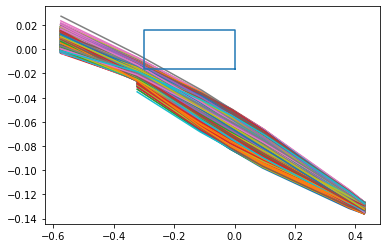

In [6]:
from shapely.geometry import LineString


def convert_position_injector_to_ring_frame(X):
    X=X[:2].copy()
    X+=-model.lattice_injector.combiner.r2[:2]
    X=model.lattice_injector.combiner.R_In@model.lattice_injector.combiner.R_In@X
    X+=model.lattice_ring.combiner.r2[:2]
    return X

def line_In_ring_frame_from_injector_particle(particle)->Optional[LineString]:
    if len(particle.el_phase_space_log)==0:
        return None
    qList=[]
    for q,p in particle.el_phase_space_log:
        qRingFrame_2D=convert_position_injector_to_ring_frame(q)
        qList.append(qRingFrame_2D)
    line=LineString(qList)
    return line

def does_ring_clip_injector_particle(particle):
    line=line_In_ring_frame_from_injector_particle(particle)
    lens=model.lattice_ring.el_list[0]
    assert len(model.lattice_ring.el_list)==5 and type(lens) is HalbachLensSim
    return line.intersects(lens.SO_outer)

clipped=0
for particle in swarm_injector_traced.particles:
    line=line_In_ring_frame_from_injector_particle(particle)
    plt.plot(*line.coords.xy)
    # model.show_floor_plan()
    # line.intersects(model.lattice_ring.el_list[0].SO_outer)
    clipped+=does_ring_clip_injector_particle(particle)
plt.plot(*model.lattice_ring.el_list[0].SO_outer.exterior.xy)
clipped

In [1]:
from helperTools import *
from latticeElements.utilities import ElementTooShortError
from latticeModels import make_ring_and_injector, RingGeometryError, InjectorGeometryError
from latticeModels_Parameters import optimizerBounds_V1_3,injectorParamsOptimalAny
from storageRingModeler import StorageRingModel
from optimizer import Solver

params=(0.021678111714888558, 0.01 , 0.03999899762130617 ,0.007616470202968745, 0.4484421625888025  , 0.49306469260734515 )

has_bumper=False
system_params=[params,tuple(injectorParamsOptimalAny.values())]

lattice_ring, lattice_injector = make_ring_and_injector(system_params,'3',options={'use_solenoid_field': True,'has_bumper': has_bumper})
model = StorageRingModel(lattice_ring, lattice_injector,has_bumper=has_bumper)
model.mode_match()

In [8]:
'a'

'a'

In [7]:
#(0.7243036492975127, 86.62969974111866)
%matplotlib tk
# model.show_floor_plan_with_trajectories()
model.mode_match() #(1.8180463499879218, 57.173734897771034)

(0.7882430184203559, 66.56575763267496)

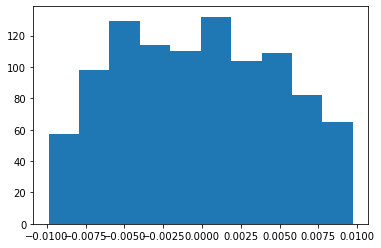

In [101]:
def timestep_particle_to_zero(particle):
    startX=-1e-10
    dx=startX-particle.qi[0]
    dt=dx/particle.pi[0]
    particle.qi+=dt*particle.pi
def displace_swarm(swarm,dx,dy,dz,move_to_zero=True):
    delta=np.array([dx,dy,dz])
    for particle in swarm:
        particle.qi+=delta
        if move_to_zero:
            timestep_particle_to_zero(particle)
def rotate_swarm_momentum(swarm,angle_y,angle_z):
    Rz=Rot.from_rotvec([0,0,angle_z]).as_matrix()
    Ry=Rot.from_rotvec([0,angle_y,0]).as_matrix()
    for particle in swarm:
        particle.pi=Rz@particle.pi
        particle.pi=Ry@particle.pi
    return swarm

def solve_Jittered_Swarm(dx,dy,dz,angle_y,angle_z):
    model=StorageRingModel(lattice_ring,lattice_injector)
    displace_swarm(model.swarm_injector_initial,dx,dy,dz)
    rotate_swarm_momentum(model.swarm_injector_initial,angle_y,angle_z)
    return model.mode_match()
def make_increasing_3D_arr_along_axis(amplitude,length,axis):
    arr=np.zeros((length,3))
    arr[:,axis]=np.linspace(-amplitude,amplitude,length)
    return arr
def make_random_arr(amplitude,length):
    return amplitude*2*(np.random.random(length)-.5)
def make_random_arr_in_circle(radius,num):
    samples=[]
    while len(samples)<num:
        x,y=make_random_arr(radius,2)
        if np.sqrt(x**2+y**2)<=radius:
            samples.append((x,y))
    return np.array(samples)

def make_misalignment_params(delta_x_max,delta_r_max,angle_max,num):
    shifts_x=make_random_arr(delta_x_max,num)
    shifts_y,shifts_z=make_random_arr_in_circle(delta_r_max,num).T
    rotsY,rotsZ=make_random_arr_in_circle(angle_max,num).T
    params=np.column_stack((shifts_x,shifts_y,shifts_z,rotsY,rotsZ))
    return params


In [1]:
from constants import GRAVITATIONAL_ACCELERATION
T=swarm.particles[0].T
z=swarm.particles[0].qf[2]
.5*GRAVITATIONAL_ACCELERATION*T**2

NameError: name 'swarm' is not defined

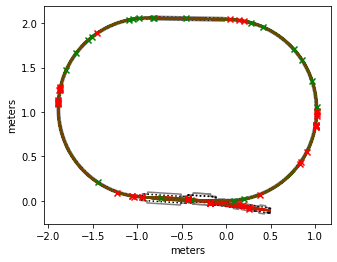

In [16]:
from latticeElements.elements import Drift,HalbachLensSim
def get_element_before_and_after(el_center,lattice):
    if (el_center.index == len(lattice.el_list) - 1 or el_center.index == 0) and lattice.lattice_type == 'injector':
        raise Exception('Element cannot be first or last if lattice is injector type')
    el_before_index = el_center.index - 1 if el_center.index != 0 else len(lattice.el_list) - 1
    el_after_index = el_center.index + 1 if el_center.index < len(lattice.el_list) - 1 else 0
    el_before = lattice.el_list[el_before_index]
    el_after = lattice.el_list[el_after_index]
    return el_before, el_after
def move_Injector_Element_Longitudinally(el_center,deltaL,lattice) -> None:
    el_before, el_after = get_element_before_and_after(el_center,lattice)
    assert all(type(el) is Drift  for el in (el_before,el_after)) and type(el_center) is HalbachLensSim
    el_before.set_length(el_before.L+deltaL)
    el_after.set_length(el_after.L-deltaL)
def twist_Knobs(shiftLens1,shiftLens2,lattice):
    lenses=[el for el in lattice.el_list if type(el) is HalbachLensSim]
    assert len(lenses)==2
    for el,shift in zip(lenses,[shiftLens1,shiftLens2]):
        move_Injector_Element_Longitudinally(el,shift,lattice)
    lattice.build_lattice(False)
import copy
def make_Injector_With_Longer_First_Drift(extraLength):
    lattice=copy.deepcopy(lattice_injector)
    first_el=lattice.el_list[0]
    first_el.set_length(first_el.L+extraLength)
    lattice.build_lattice(False)
    return lattice
%matplotlib inline
PTL=make_Injector_With_Longer_First_Drift(-.1)
optimizer = StorageRingModel(lattice_ring, PTL)
optimizer.show_floor_plan_with_trajectories()

In [2]:
from KevinBumperClass import clone_bumper,r1p2
from ParticleTracerLatticeClass import ParticleTracerLattice
from latticeElements.elements import CombinerIdeal,CombinerSim,CombinerHalbachLensSim

In [11]:
%matplotlib inline
PTL_Full_Injector=clone_bumper()

for el in lattice_injector.el_list:
    if type(el) in (CombinerIdeal,CombinerSim,CombinerHalbachLensSim):
        assert PTL_Full_Injector.combiner is None  # there can be only one!
        PTL_Full_Injector.combiner = el
    el.index=len(PTL_Full_Injector.el_list)
    PTL_Full_Injector.el_list.append(el)
PTL_Full_Injector.end_lattice()

model = StorageRingModel(lattice_ring, PTL_Full_Injector,has_bumper=True)
for particle in model.swarm_injector_initial:
    particle.obj_qi = particle.qi.copy()
    t = -abs((r1p2 * 1.5  / particle.pi[0]))
    particle.qi[1:]+=t*particle.pi[1:]

In [5]:
%matplotlib tk
model.show_floor_plan_with_trajectories()

In [6]:
%matplotlib inline
#(0.7291830589819795, 85.09648468476328)
model.mode_match(parallel=True)

(0.7725385562536252, 71.47325862029271)

In [17]:
from ParticleClass import Swarm
def make_Kevin_Swarm():
    data=np.loadtxt('kevin_bumper_phase.txt')[:1000]
    q_arr=data[:,:3]
    p_arr=data[:,3:]
    q_arr[:,0]*=-1
    q_arr[:,1]*=-1
    # q_arr[:,1]+=KevinBumper.start
    p_arr[:,0]*=-1
    p_arr[:,1]*=-1
    swarm=Swarm()
    for q,p in zip(q_arr,p_arr):
        swarm.add_new_particle(qi=q,pi=p)
    return swarm




In [18]:
model=StorageRingModel(lattice_ring,PTL_Full_Injector,use_energy_correction=True,has_bumper=True)
model.swarm_injector_initial=make_Kevin_Swarm()
model.show_floor_plan_with_trajectories(T_max=.04)

In [70]:
def solve_Displaced(dx=0.0,dy=0.0,dz=0.0):
    model=StorageRingModel(lattice_ring,PTL_Full_Injector,use_energy_correction=True,has_bumper=True)
    model.swarm_injector_initial=make_Kevin_Swarm()
    displace_swarm(model.swarm_injector_initial,dx,dy,dz,move_to_zero=False)
    return model.mode_match()
solve_Displaced(dx=3e-3,dy=3e-3,dz=3e-3)

(1.86813331062945, 41.43533883171946)

In [ ]:
model=StorageRingModel(lattice_ring,lattice_injector,use_energy_correction=True)


In [13]:
%matplotlib tk
from SwarmTracerClass import SwarmTracer
st=SwarmTracer(PTL_Full_Injector)
swarm=st.initialize_simulated_collector_focus_swarm(100)

for particle in swarm:
    particle.obj_qi = particle.qi.copy()
    t = -abs((KevinBumper.r1p2 * 1.5  / particle.pi[0]))
    particle.qi[1:]+=t*particle.pi[1:]


swarm=st.trace_swarm_through_lattice(swarm,1e-5,1.0,use_fast_mode=False,copy_swarm=True)
PTL_Full_Injector.show_lattice(swarm=swarm,show_trace_lines=True)
# swarm.survival_rev() #0.4573977480905923

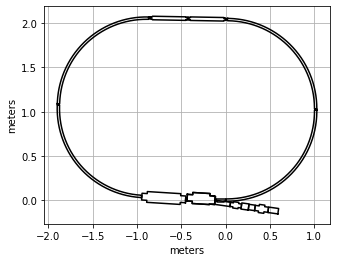

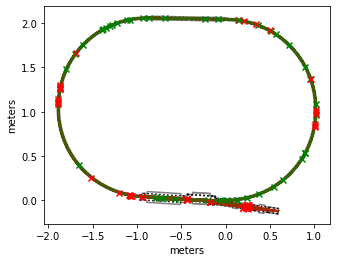

In [49]:
model=StorageRingModel(lattice_ring,lattice_injector,use_energy_correction=True)

In [9]:
%matplotlib inline
from helperTools import parallel_evaluate
def shifted_Swarm_Cost(loadingShift):
    try:
        PTL_Injector_Long=make_Injector_With_Longer_First_Drift(loadingShift)
    except:
        return 1.0,0.0
    optimizer = StorageRingModel(lattice_ring, PTL_Injector_Long)
    return optimizer.mode_match(True) #(0.6319767830742709, 5.7820389531454275)
shifts=np.linspace(-.03,.03,9)
results=parallel_evaluate(shifted_Swarm_Cost,shifts,processes=len(shifts))

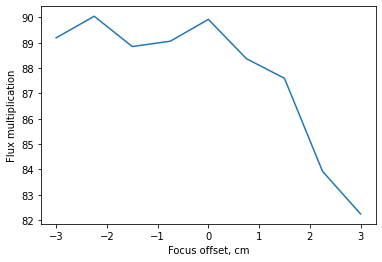

In [12]:
y=[res[1] for res in results]
plt.plot(shifts*100,y)
plt.xlabel("Focus offset, cm")
plt.ylabel("Flux multiplication")
plt.show()

In [65]:
from latticeModels_Parameters import injectorParamsOptimalAny
gap0=injectorParamsOptimalAny["gap1"]

def shifted(delta):
    injectorParamsOptimalAny.super_Special_Change_Item("gap1",gap0+delta)
    lattice_ring, lattice_injector = make_Ring_And_Injector_Version3(params)
    optimizer = StorageRingModel(lattice_ring, lattice_injector)
    return optimizer.mode_match(True)
shifts=np.linspace(-.03,.03,5)
results=parallel_evaluate(shifted,shifts,processes=len(shifts))
injectorParamsOptimalAny.super_Special_Change_Item("gap1",gap0)

In [66]:
results

[(0.7515676046473709, 78.06278088384927),
 (0.7710486067024354, 71.94143268904661),
 (0.7916690485230207, 65.46204810925506),
 (0.80718621273004, 60.58622268515165),
 (0.8313210236361606, 53.00254804898593)]

In [35]:
from optimizer import Solver
from helperTools import *
from parallel_Gradient_Descent import gradient_Descent
def solve(x):
    solver=Solver('both',None,use_energy_correction=True)
    sol=solver.solve(x)
    return sol.cost

0.01884943975425587

In [38]:
max((1,2,'a'))

TypeError: '>' not supported between instances of 'str' and 'int'

In [23]:
a=np.zeros((7,3))
a[1,1]=2.0
a[5,1]=3.0
display(a)

valid_indices=a[:,1]!=0.0 #avoid using == with float unless you're sure you can!
display(a[valid_indices])

array([[0., 0., 0.],
       [0., 2., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

array([[0., 2., 0.]])

In [34]:
x=np.linspace(0.0,.004,2)
y=np.linspace(0.0,2.0, 3)
X,Y=np.meshgrid(x,y)
display(x)
display(X)
display(y)
display(Y)

array([0.   , 0.004])

array([[0.   , 0.004],
       [0.   , 0.004],
       [0.   , 0.004]])

array([0., 1., 2.])

array([[0., 0.],
       [1., 1.],
       [2., 2.]])

array([0., 0., 1., 0., 1., 2.])

In [ ]:
swarm_injector_traced.particles[5].el_phase_space_log[-1][0]

In [ ]:
# PTL = ParticleTracerLattice(200.0, lattice_type='storage_ring')
#
# PTL.add_halbach_lens_sim(.01, .5)
# PTL.add_drift(.1)
# PTL.add_combiner_sim_lens(.1, .02)
# PTL.add_halbach_lens_sim(.01, .5)
# PTL.add_segmented_halbach_bender(.0254 / 2, .01, None, 1, 0.0, r_offset_fact=1.)
# PTL.add_halbach_lens_sim(.01, 1., constrain=True)
# PTL.add_segmented_halbach_bender(.0254 / 2, .01, None, 1, 0.0, r_offset_fact=1.)
# PTL.end_lattice(enforceClosedLattice=False, constrain=True,surpressWarning=True)

In [ ]:
def get_Error(fact):
    PTL = ParticleTracerLattice(200.0, lattice_type='storage_ring')


    PTL.add_drift(.1)
    PTL.add_segmented_halbach_bender(.0254 / 2, .01, 300, 1, 0.0, r_offset_fact=fact)
    PTL.end_lattice(enforceClosedLattice=False, constrain=False,surpressWarning=True)

    from ParticleTracerClass import ParticleTracer
    from ParticleClass import Particle
    pt=ParticleTracer(PTL)
    particle=Particle(qi=np.array([-1e-10,-.1e-3,0.0]))

    particle=pt.trace(particle,1e-5,.01,use_fast_mode=False,accelerated=False)
    PTL.show_lattice(particle=particle,show_trace_lines=True,true_aspect_ratio=False)
    particle.plot_orbit_reference_frame_position()
    particle.plot_energies(show_only_total_energy=True)
    error=np.std([q[1] for q in particle.qo_vals])
    return error #0.0003401014791188453
# offsetList=list(np.linspace(.95,1.1,10))
# errors=[get_Error(offset) for offset in offsetList]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(offsetList,errors)
plt.show()

In [ ]:

PTL = ParticleTracerLattice(200.0, lattice_type='storage_ring')
PTL.add_drift(.1)
PTL.add_combiner_sim_lens(.15,.04)
# PTL.add_halbach_lens_sim(.02,.1,.9)
# PTL.add_drift(.1)
# PTL.add_segmented_halbach_bender(.0254 / 2, .01, 300, 1, 0.0)
PTL.end_lattice(enforceClosedLattice=False, constrain=False,surpressWarning=True)
from ParticleTracerClass import ParticleTracer
from ParticleClass import Particle
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,2e-3,0.0]))
particle=pt.trace(particle,1e-5,.01,use_fast_mode=False,accelerated=False)
%matplotlib inline
PTL.show_lattice(particle=particle,show_trace_lines=True,true_aspect_ratio=False)



In [ ]:
PTL.el_list[1].force(np.array([.1,0,0]))
PTL.el_list[1].r2

In [ ]:
[q[1] for q in particle.qo_vals]

In [ ]:
particle.plot_orbit_reference_frame_position()

In [ ]:
%matplotlib inline
from storageRingGeometries import Line,Kink,CappedSlicedBend
from storageRingGeometry import StorageRingGeometry
from storageRingGeometrySolver import StorageRingConstraintSolver
first_el=Line(.5)
first_el.place(np.array([0.0,0.0]),-np.pi)
L_cap=0.02135#PTL_True.bender1.L_cap



elements=[
    first_el,
    Line(.1),
    Kink(-0.07288109082330438,L2,L1),
    Line(.5),
    CappedSlicedBend(.0127,240,magnet_depth,L_cap,1.),
    Line(1.5,constrained=True),
    CappedSlicedBend(.0127,230,magnet_depth,L_cap,1.0042770601252802)
]



storage_ring=StorageRingGeometry(elements)
storage_ring.build()
storage_ring.show_geometry()
solver=StorageRingConstraintSolver(storage_ring,1.0)
params=solver.solve()
solver.update_ring(params)
storage_ring=solver.storage_ring
# storage_ring=solver.make_valid_storage_ring()
storage_ring.show_geometry()
params

In [ ]:
import matplotlib.pyplot as plt
def build(PTL,storage_ring):
    #todo: assert that each element lines up as expected
    for i,elements in enumerate(zip(PTL.el_list,storage_ring)):
        el_PTL,el_Geom=elements
        if type(el_Geom) is Line:
            el_PTL.r1=np.array([*el_Geom.pos_in,0])
            el_PTL.r2=np.array([*el_Geom.pos_out,0])
            el_PTL.nb=np.array([*el_Geom.norm_in,0])
            el_PTL.ne=np.array([*el_Geom.norm_out,0])

            theta=np.arctan2(el_Geom.norm_out[1],el_Geom.norm_out[0])
            if theta<0:
                theta+=np.pi*2
            el_PTL.theta=theta
            el_PTL.R_Out = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
            el_PTL.R_In = np.asarray([[np.cos(-theta), -np.sin(-theta)], [np.sin(-theta), np.cos(-theta)]])
        if type(el_Geom) is Kink:

            n_out_perp=-np.flip(el_Geom.norm_out)*np.array([-1,1])
            # r2+
            r2=(el_Geom.pos_out+n_out_perp*el_PTL.output_offset)
            el_PTL.r2=np.array([*r2,0.0])
            el_PTL.r2[1]=0.014609633588606709

            r1=r2+-el_Geom.norm_out*el_PTL.Lb+el_Geom.norm_in*el_PTL.La
            el_PTL.r1=np.array([*r1,0])

            el_PTL.nb=np.array([*el_Geom.norm_in,0])
            el_PTL.ne=np.array([*el_Geom.norm_out,0])

            theta=np.arctan2(el_Geom.norm_out[1],el_Geom.norm_out[0])-np.pi #todo: i think this might be wrong, or not the right way to hink about it

            theta=theta+2*np.pi #conventino
            el_PTL.theta=theta

            rot=el_PTL.theta
            el_PTL.R_Out = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
            rot=-rot
            el_PTL.R_In = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])#np.linalg.inv(el_PTL.R_Out)
        if type(el_Geom) is CappedSlicedBend:
            print("need to include shifting this over for offset effect")

            el_PTL.r1=np.array([*el_Geom.pos_in,0])
            el_PTL.r2=np.array([*el_Geom.pos_out,0])
            el_PTL.nb=np.array([*el_Geom.norm_in,0])
            el_PTL.ne=np.array([*el_Geom.norm_out,0])
            el_PTL.r0=np.array([*el_Geom.benderCenter,0])
            # print(el_PTL.r1)
            n=-el_Geom.norm_in
            theta=np.arctan2(n[1],n[0])
            if theta<0:
                theta+=np.pi*2
            print(n,theta)
            el_PTL.theta=theta

            rot=el_PTL.theta- el_PTL.ang + np.pi / 2
            el_PTL.R_Out = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
            rot=-rot
            el_PTL.R_In = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])#np.linalg.inv(el_PTL.R_Out)

build(PTL,storage_ring)
# %matplotlib tk
PTL.make_Geometry()
PTL.show_lattice(true_aspect_ratio=True)

In [ ]:
%matplotlib inline
from ParticleTracerClass import ParticleTracer
from ParticleClass import Particle
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,-.1e-3,0.0]))

particle=pt.trace(particle,1e-5,1,use_fast_mode=False,accelerated=False)
PTL.show_lattice(particle=particle,show_trace_lines=True,true_aspect_ratio=False)
np.set_printoptions(precision=100)
print(particle.qf) #[-7.3317516263831284e-01  3.4424809584164646e-03 -5.2940775338183833e-06]

In [ ]:
particle.plot_orbit_reference_frame_position()

In [ ]:
el=PTL.el_list[-1]
q=np.array([.5,.5,0])
# print(el.r1,el.r2)
# print(el.R_Out)
# print(el.r2)
# print(el.transform_element_coords_into_lab_frame(q))
# print(el.R_Out)#@q[:2])#+el.r1[:2])
print(el.R_Out)
print(el.R_In)

In [ ]:
PTL_Compare = ParticleTracerLattice(200.0, lattice_type='storage_ring')


PTL_Compare.add_halbach_lens_sim(.01, .5)
PTL_Compare.add_combiner_sim_lens(.1, .02)
PTL_Compare.add_halbach_lens_sim(.01, .5)
PTL_Compare.add_segmented_halbach_bender(.0254 / 2, .01, 251, 1.0419898531028318, 0.0, r_offset_fact=1.)
PTL_Compare.add_halbach_lens_sim(.01, 1.1156855236430039, constrain=True)
PTL_Compare.add_segmented_halbach_bender(.0254 / 2, .01, 251, 1.0418702761406033, 0.0, r_offset_fact=1.)
PTL_Compare.end_lattice(enforceClosedLattice=True, constrain=True,surpressWarning=True)


In [ ]:
PTL_Compare.bender1.rb,PTL_Compare.bender2.rb,PTL_Compare.bender1.num_magnets,PTL_Compare.bender2.num_magnets

In [ ]:
el=PTL_Compare.el_list[-1]
q=np.array([.5,.5,0])
# print(el.r1,el.r2)
# print(el.R_Out)
# print(el.r2)
# print(el.transform_element_coords_into_lab_frame(q))
# print(el.R_Out)#@q[:2])#+el.r1[:2])
print(el.R_Out)
print(el.R_In)


In [ ]:
from ParticleTracerClass import ParticleTracer
from ParticleClass import Particle
pt=ParticleTracer(PTL_Compare)
particle=Particle(qi=np.array([-1e-10,-1e-3,0.0]))

particle=pt.trace(particle,1e-5,1,use_fast_mode=False,accelerated=False)
PTL_Compare.show_lattice(particle=particle,show_trace_lines=True,true_aspect_ratio=False)
np.set_printoptions(precision=100)
print(particle.qf) #[-6.287784633004588e-01 -3.911591601543401e-03 -4.206831835417686e-06]

In [ ]:
particle.plot_orbit_reference_frame_position()

In [ ]:
#set first element
PTL.el_list[0].r1=storage_ring.elements[0].pos_in
PTL.el_list[0].r2=storage_ring.elements[0].pos_out
n=storage_ring.elements[0].norm_out
theta=np.arctan2(n[1],n[0])
PTL.el_list[0].theta=theta
rot=theta
PTL.el_list[0].R_Out = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
#rotating out of the element reference frame

In [ ]:
#set combiner
combEl=PTL.el_list[1]
combShape=storage_ring.elements[1]
n_out_perp=-np.flip(combShape.norm_out)*np.array([-1,1])
# r2+
r2=(combShape.pos_out+n_out_perp*combEl.output_offset)
combEl.r2=np.array([r2[0],r2[1],0.0])

r1=r2+-combShape.norm_out*combEl.Lb+combShape.norm_in*combEl.La
combEl.r1=np.array([r1[0],r1[1],0])

theta=PTL.el_list[0].theta
theta = 2 * np.pi - combEl.ang - (
        np.pi - theta)  # Tilt the combiner down by el.ang so y=0 is perpindicular
# to the input. Rotate it 1 whole revolution, then back it off by the difference. Need to subtract
# np.pi because the combiner's input is not at the origin, but faces 'east'
theta = theta - 2 * np.pi * (theta // (2 * np.pi))  # the above logic can cause the element
# to have to rotate more than 360 deg


combEl.theta=theta

rot=combEl.theta
combEl.R_Out = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
#rotating out of the element reference frame
theta,combEl.ang

In [ ]:
PTL.make_Geometry()

In [ ]:
%matplotlib tk
PTL.show_lattice()

In [11]:
from numba_stats import norm
norm.pdf(0.0,0.0,10.0)

array(0.03989423)

In [ ]:
from SwarmTracerClass import SwarmTracer
st=SwarmTracer(PTL_True)
swarm=st.initalize_pseudorandom_swarm_in_phase_space(5e-3,5.0,1.0,1000)
swarm=st.trace_swarm_through_lattice(swarm,5e-6,1,use_fast_mode=True)

In [38]:
from helperTools import *
from constants import *
rp=.6
T=.01
vRel=1e2*np.sqrt(16 * BOLTZMANN_CONSTANT*T/(3.14 *MASS_LITHIUM_7))
sigma=5e-13
v=210*1e2
Flux=2e12*500
A=np.pi*(.7*rp)**2
I=Flux/A
n=I/v
l=1/(np.sqrt(2)*n*sigma)
vRel/l

47.21549651412601

In [42]:
float_Kelvin=float
float_meters=float
def scattering_Rate(T: float_Kelvin,rp: float_meters):
    assert rp<.1 and T<.1 #reasonable values
    rp*=1e2 #convert to cm
    vRel=1e2*np.sqrt(16 * BOLTZMANN_CONSTANT*T/(3.14 *MASS_LITHIUM_7)) #cm/s
    sigma=5e-13 #cm^2
    speed=210*1e2 #cm^2
    flux=2e12*500 #1/s
    area=np.pi*(.7*rp)**2 #cm
    n=flux/(area*speed) #1/cm^3
    meanFreePath=1/(np.sqrt(2)*n*sigma)
    return vRel/meanFreePath
scattering_Rate(.01,.01)

16.997578745085367

In [90]:
import numba
from numba.experimental import jitclass
@jitclass([('a',numba.types.unicode_type),
           ('b',numba.float64),
           ('c',numba.int64)])
class poop:
    def __init__(self):
        self.a='a'
        self.b=2.0
        self.c=3

poo=poop()
%timeit poop()

2.63 µs ± 38.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


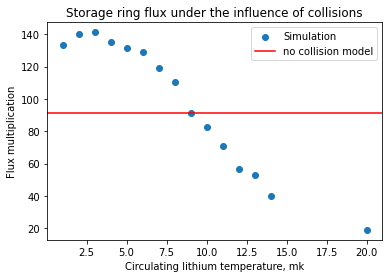

In [103]:
res=[133.12747755802948, 140.27885009841324, 141.22793660956452, 135.4874919947779, 131.72251599032012, 129.17155980008903, 119.28016157792038, 110.6190413848261, 91.54714335716547, 82.63165617539292, 70.64025870944323, 56.4425280821248, 52.62536289967612, 40.19285010371332, 18.948608342594255]

T_arr=np.arange(0.001,.015,.001)
T_arr=1e3*np.append(T_arr,.02)
plt.scatter(T_arr,res,label='Simulation')
plt.title("Storage ring flux under the influence of collisions")
plt.ylabel("Flux multiplication")
plt.xlabel("Circulating lithium temperature, mk")
plt.axhline(y=91,c='r',label='no collision model')
plt.legend()
plt.show()

In [69]:
@numba.njit
def mixed_value_type_str_key_dict():
    # str -> mixed types, including array and typed dictionary!
    a = {'a': 1, 'b': 'string', 'c': np.arange(5), 'd': {10:20, 30:40}}

    print('getitem', a['d']) # getitem works
    [print("key", k) for k in a.keys()] # keys() works
    print('len', len(a)) # non-mutating call on the dictionary is ok
    print("contains ", 'a' in a, 'z' in a) # and contains as it's read only
    # it's slightly contrived, but .items() also works


mixed_value_type_str_key_dict()

getitem {10: 20, 30: 40}
key a
key b
key c
key d
len 4
contains  True False


In [123]:
def full_arctan2(q):
    """Compute angle spanning 0 to 2pi degrees as expected from x and y where q=numpy.array([x,y,z])"""
    phi = np.arctan2(q[1], q[0])
    if phi < 0:  # confine phi to be between 0 and 2pi
        phi += 2 * np.pi
    return phi

In [76]:
#values
s0=210.0
T=.01

In [170]:
# lens

rp=.02
q_el=np.array([.2,rp/3,-rp/2])
x,y,z=q_el

sigma=np.sqrt(BOLTZMANN_CONSTANT*T/MASS_LITHIUM_7)
FWHM=2.355*sigma
trapFactY=(1-(y/rp)**2)
trapFactZ=(1-(z/rp)**2)
assert trapFactZ>=0.0 and trapFactY>=0.0
delta_px,py,pz=FWHM*2*(np.random.random_sample(3)-.5)
py,pz=py*trapFactY,pz*trapFactZ
px=s0+delta_px
pCollision=(px,py,pz)
pCollision

(205.89436883373398, 4.881527298918776, -0.19991783017430087)

In [171]:

theta=1.215
rp=.02
ro=1.01
r=1.011
x,y=r*np.cos(theta),r*np.sin(theta)
z=rp/5.0
q_el=np.array([x,y,z])


In [197]:

#bender
theta=full_arctan2(q_el)
r=np.sqrt(x**2+y**2)
xo=r-ro
yo=q_el[2]
trapFactXo=(1-(xo/rp)**2) if xo<=rp else 0.0
trapFactYo=(1-(yo/rp)**2)
assert all(0.0<=fact<=1.0 for fact in (trapFactYo,trapFactXo))
L=s0*ro
delta_pso,pxo,pyo=FWHM*2*(np.random.random_sample(3)-.5)
pso=L/r+delta_pso
pCollision=np.array([pso,pxo,pyo])



array([208.82260908,   6.50248248,  -2.19312246])

In [175]:
l=s0*r
l/(r+rp),s0


(205.9262851600388, 210.0)